# 00 - Preparations

In [1]:
from owslib.wms import WebMapService
from types import SimpleNamespace
from pathlib import Path
from tqdm import tqdm
import yaml

import random
import shutil
import os

In [2]:
CFG = SimpleNamespace()
CFG.WMS_URL = 'http://geoservices.buergernetz.bz.it/mapproxy/root/ows?'

# 01 - Explore WMS service (only for testing)

https://owslib.readthedocs.io/en/latest/usage.html#

### Find out what a WMS has to offer (service metadata)

In [ ]:
wms = WebMapService(CFG.WMS_URL)
wms.identification.type

In [ ]:
wms.identification.version

In [ ]:
wms.identification.title

In [ ]:
wms.identification.abstract

### Available layers

In [ ]:
list(wms.contents)

In [ ]:
# Select the layer for future use
CFG.LAYER_NAME = 'p_bz-Orthoimagery:Aerial-2023-RGB'

### Details of a layer

In [ ]:
wms[CFG.LAYER_NAME].title

In [ ]:
wms[CFG.LAYER_NAME].queryable

In [ ]:
wms[CFG.LAYER_NAME].opaque

In [ ]:
wms[CFG.LAYER_NAME].boundingBox

In [ ]:
wms[CFG.LAYER_NAME].boundingBoxWGS84

In [ ]:
wms[CFG.LAYER_NAME].crsOptions

In [ ]:
wms[CFG.LAYER_NAME].styles

### Available methods, their URLs, and available formats

In [ ]:
[op.name for op in wms.operations]

In [ ]:
wms.getOperationByName('GetMap').methods

In [ ]:
wms.getOperationByName('GetMap').formatOptions

### Make a request for imagery

In [ ]:
img = wms.getmap(
    layers=[CFG.LAYER_NAME],
    #styles=['visual_bright'],
    srs='EPSG:3857', # Web Mercator
    bbox=(1242657, 5878915, 1242757, 5879015),
    size=(640, 640),
    format='image/jpeg',
    transparent=True,
    )

out = open('test_image.jpg', 'wb')
out.write(img.read())
out.close()

# 02 - Download images from WMS

## Function to load images from WMS

In [4]:
def load_and_save_images_from_wms(
        url: str,
        layer_name: str,
        coords_center: tuple,
        img_size: tuple,
        resolution: float,
        path: Path,
        filename: str,
        ):
    """
    Load and save images from a WMS server based on given coordinates and resolution.
    Parameters:
    url (str): The WMS server URL.
    coords_center (tuple): The x and y coordinates of the center point.
    img_size (tuple): The size of the image (width, height) in pixels.
    resolution (float): The resolution in meters per pixel.
    """

    wms = WebMapService(url)

    x_min = coords_center[0] - (img_size[0] * resolution) / 2
    x_max = coords_center[0] + (img_size[0] * resolution) / 2
    y_min = coords_center[1] - (img_size[1] * resolution) / 2
    y_max = coords_center[1] + (img_size[1] * resolution) / 2

    img = wms.getmap(
        layers=[layer_name],
        srs='EPSG:3857', # Web Mercator
        bbox=(x_min, y_min, x_max, y_max),
        size=img_size,
        format='image/jpeg',
        transparent=True,
        )
    
    # Create a world file for georeferencing
    world_file_content = f"{resolution}\n0.0\n0.0\n-{resolution}\n{x_min}\n{y_max}\n"
    world_file_path = path / f'{filename}.jgw'
    with open(world_file_path, 'w') as world_file:
        world_file.write(world_file_content)

    out = open(path / f'{filename}.jpg', 'wb')
    out.write(img.read())
    out.close()

In [7]:
CFG.LAYER_NAME = 'p_bz-Orthoimagery:Aerial-2023-RGB'
#CFG.LAYER_NAME = 'p_bz-Orthoimagery:Aerial-2020-RGB'
#CFG.LAYER_NAME = 'p_bz-Orthoimagery:Aerial-2014-RGB'

CFG.IMG_SIZE = (640, 640)
CFG.RESOLUTION = 0.2
CFG.PATH = Path().cwd() / 'raw_images_640x640'

In [26]:
# load_and_save_images_from_wms(
#     url=CFG.WMS_URL,
#     layer_name=CFG.LAYER_NAME,
#     coords_center=(1242660, 5878955),
#     img_size=CFG.IMG_SIZE,
#     resolution=CFG.RESOLUTION,
#     path=CFG.PATH,
#     filename='0',
#     )

### Download the images in a specified grid

In [8]:
# Set the raster size and center
CFG.RASTER_CENTER = (1241920, 5879135)
CFG.RASTER_SIZE = (10, 10)  # Number of images in x and y direction

x_step = CFG.IMG_SIZE[0] * CFG.RESOLUTION
y_step = CFG.IMG_SIZE[1] * CFG.RESOLUTION

for col_x in tqdm(range(CFG.RASTER_SIZE[0]), desc='Column'):
    for row_y in range(CFG.RASTER_SIZE[1]):

        # Calculate the coordinates for the center of the image
        coords_center = (
            CFG.RASTER_CENTER[0] + col_x * x_step,
            CFG.RASTER_CENTER[1] + row_y * y_step,
        )

        # Load and save the image
        filename = f'{int(coords_center[0])}_{int(coords_center[1])}'
        load_and_save_images_from_wms(
            url=CFG.WMS_URL,
            layer_name=CFG.LAYER_NAME,
            coords_center=coords_center,
            img_size=CFG.IMG_SIZE,
            resolution=CFG.RESOLUTION,
            path=CFG.PATH,
            filename=filename,
            )

CFG

Column: 100%|██████████| 10/10 [01:48<00:00, 10.82s/it]


namespace(WMS_URL='http://geoservices.buergernetz.bz.it/mapproxy/root/ows?',
          LAYER_NAME='p_bz-Orthoimagery:Aerial-2023-RGB',
          IMG_SIZE=(640, 640),
          RESOLUTION=0.2,
          PATH=WindowsPath('c:/Users/thoma/Documents/GitHub/WING_YOLO/raw_images_640x640'),
          RASTER_CENTER=(1241920, 5879135),
          RASTER_SIZE=(10, 10))

# 03 - Annotations

https://labelstud.io/blog/get-started-using-segment-anything/



### Loaded and annotated images

- p_bz-Orthoimagery:Aerial-2023-RGB
    - Tscherms, Gampenstraße - RASTER_CENTER = (1241065, 5882875), RASTER_SIZE = (4, 4)
    - Meran, Pröfingerstraße - RASTER_CENTER = (1244510, 5888300), RASTER_SIZE = (4, 4)
    - Bozen, Lagederweg - RASTER_CENTER = (1262665, 5861920), RASTER_SIZE = (4, 4)
    - Girlan, Marktgasse - RASTER_CENTER = (1255775, 5854640), RASTER_SIZE = (4, 4)

    - Naturns, Industriestraße - CFG.RASTER_CENTER = (1225525, 5884650), RASTER_SIZE = (4, 4)
    - Tschars, Pardellweg - CFG.RASTER_CENTER = (1217930, 5883325), RASTER_SIZE = (4, 4)
    - Reschen, Neudorfstraße - CFG.RASTER_CENTER = (1171250, 5914185), RASTER_SIZE = (4, 4)
    - Tramin, Im Bad - CFG.RASTER_CENTER = (1251630, 5834995), RASTER_SIZE = (4, 4)

    - Glurns, Max Valier Straße - CFG.RASTER_CENTER = (1175735, 5888505), RASTER_SIZE = (4, 4)
    - Salurn, Aldo Moro Straße - CFG.RASTER_CENTER = (1248340, 5819545), RASTER_SIZE = (4, 4)
    - Karezza, Piazweg - CFG.RASTER_CENTER = (1290030, 5846415), RASTER_SIZE = (4, 4)
    - Mitterolang, Hermann von Gilm Weg, CFG.RASTER_CENTER = (1338945, 5903120), RASTER_SIZE = (4, 4)
    - Antholz Niedertal, CFG.RASTER_CENTER = (1345605, 5914635), RASTER_SIZE = (2, 4)

    - Salurn, Staatsstraße - CFG.RASTER_CENTER = (1248205, 5819575), RASTER_SIZE = (3, 3)
    - Neumarkt, Untere Inselstraße - CFG.RASTER_CENTER = (1253715, 5831670), RASTER_SIZE = (3, 3)
    - Neumarkt, Obstgenossenschaft - CFG.RASTER_CENTER = (1253985, 5835220), RASTER_SIZE = (3, 3)
    - Branzoll, Raifgasse - CFG.RASTER_CENTER = (1260615, 5845090), RASTER_SIZE = (4, 4)
    - Leifers, Weinbergstraße - CFG.RASTER_CENTER = (1261765, 5848395), RASTER_SIZE = (1, 7)


- p_bz-Orthoimagery:Aerial-2014-RGB
    - Tscherms, Seidlgasse - CFG.RASTER_CENTER = (1240715, 5882560), CFG.RASTER_SIZE = (4, 5)
    - Meran, Schennastraße - CFG.RASTER_CENTER = (1244405, 5888340), CFG.RASTER_SIZE = (4, 5)
    - Kaltern, Lavardistraße, CFG.RASTER_CENTER = (1251175, 5845885), CFG.RASTER_SIZE = (4, 5)
    - Leifers, St. Jakob Straße - CFG.RASTER_CENTER = (1261895, 5853150), CFG.RASTER_SIZE = (4, 5)
    - Tisens, Tirolerstraße - CFG.RASTER_CENTER = (1243470, 5871345), CFG.RASTER_SIZE = (4, 5)


- p_bz-Orthoimagery:Aerial-2020-RGB
    - Gufidaun, Hauptstraße - CFG.RASTER_CENTER = (1291305, 5884875), CFG.RASTER_SIZE = (4, 5)
    - St. Peter, Oberhausweg - CFG.RASTER_CENTER = (1300345, 5883915), CFG.RASTER_SIZE = (4, 5)
    - Klausen, Fragburg - CFG.RASTER_CENTER = (1286940, 5883185), CFG.RASTER_SIZE = (4, 5)
    - Raas, Kirchweg - CFG.RASTER_CENTER = (1297965, 5901345), CFG.RASTER_SIZE = (4, 5)
    - Neustift, Kapuzinerring - CFG.RASTER_CENTER = (1254800, 5830815), CFG.RASTER_SIZE = (4, 5)



# 04 - Prepare dataset

- Export annotated images in YOLO-format

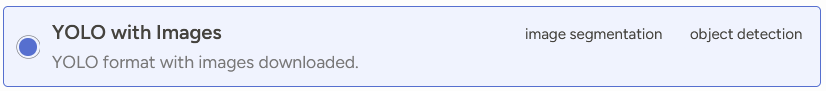

- unzip file and move the content to .\annotation_export
- run the code below
    - the first cell to delete the existing dataset
    - the second cell to split the images in train/val and move them to the directories

In [ ]:
# Delete the directory if it exists
CFG.DATASET_DIR_PARENT = Path().cwd() / 'dataset'

if CFG.DATASET_DIR_PARENT.exists() and CFG.DATASET_DIR_PARENT.is_dir():
    shutil.rmtree(CFG.DATASET_DIR_PARENT)

# Create the directories if they don't exist
dataset_dir_list = [
    CFG.DATASET_DIR_PARENT / 'images' / 'train',
    CFG.DATASET_DIR_PARENT / 'images' / 'val',
    CFG.DATASET_DIR_PARENT / 'labels' / 'train',
    CFG.DATASET_DIR_PARENT / 'labels' / 'val',
    ]

for path in dataset_dir_list:
    path.mkdir(parents=True)

In [ ]:
path = Path().cwd() / 'annotation_export' / 'images'

# Find all the images in the folder
images = list(path.glob('*.jpg'))
print(f'{len(images)} images found in {path}')

# Set the number of images for training and validation
n_val = int(len(images) * 0.2)

# Take a random sample of 10 images for validation
val_images = random.sample(images, n_val)

for image in val_images:

    # Get the image name without the extension
    image_name = os.path.splitext(image.name)[0]

    # Get the corresponding label path
    label = path.parent / 'labels' / f'{image_name}.txt'

    # Create the new path for the image and label
    new_image_path = Path().cwd() / 'dataset' / 'images' / 'val' / f'{image_name}.jpg'
    new_label_path  = Path().cwd() / 'dataset' / 'labels' / 'val' / f'{image_name}.txt'

    # Move the files to the new path
    shutil.move(image, new_image_path)
    shutil.move(label, new_label_path)

print(f'{len(val_images)} images moved to validation set')

# Find all the images in the folder
images = list(path.glob('*.jpg'))

# Move the rest of the images to the training set
for image in images:
    # Get the image name without the extension
    image_name = os.path.splitext(image.name)[0]

    # Get the corresponding label path
    label = path.parent / 'labels' / f'{image_name}.txt'

    # Create the new path for the image and label
    new_image_path = Path().cwd() / 'dataset' / 'images' / 'train' / f'{image_name}.jpg'
    new_label_path  = Path().cwd() / 'dataset' / 'labels' / 'train' / f'{image_name}.txt'

    # Move the files to the new path
    shutil.move(image, new_image_path)
    shutil.move(label, new_label_path)

print(f'{len(images)} images moved to train set')